In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy
import random as r
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import keras


In [3]:
pip install simpleitk

Note: you may need to restart the kernel to use updated packages.


In [4]:
yol='/content/drive/MyDrive/data_training/HGG/'


In [5]:
import os
os.listdir(yol)

FileNotFoundError: [WinError 3] Sistem belirtilen yolu bulamıyor: '/content/drive/MyDrive/data_training/HGG/'

In [ ]:
len(os.listdir(yol))

In [ ]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import random as r

def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        
        if label == 1:
            img[img != 0 ] = 1 # tam tümör
        if label == 2:
            img[img != 1 ] = 0 # nekroz
        if label == 3:
            img[img == 2 ] = 0 # ödemsiz tümör
            img[img != 0 ] = 1
        if label == 4:
            img[img != 4 ] = 0 # genişleyen tümör
            img[img == 4 ] = 1
         
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!


def train_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        img = (img-img.mean())/ img.std()
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!

In [ ]:
flair=train_array(yol,'**/*flair.nii.gz')
t2=train_array(yol,'**/*t2.nii.gz')
seg = seg_array(yol,'**/*seg.nii.gz',1)
seg_orj = seg_array(yol,'**/*seg.nii.gz',1)

In [ ]:
flair.shape, seg.shape, t2.shape

In [ ]:
flair.dtype, seg.dtype, t2.dtype

In [ ]:
x_train = np.concatenate((flair,t2),axis=1)
x_train.dtype, x_train.shape

In [6]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate,Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

K.set_image_data_format('channels_first')


def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
def unet_model():
    
    inputs = Input((2, 240 , 240))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

model = unet_model()

C:\Users\ckmzb\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [7]:
model.fit(x_train,seg,validation_split=0.20,batch_size=10,epochs=1,shuffle=True,verbose=1)

NameError: name 'x_train' is not defined

In [8]:
seg_geniş   = seg_array(yol,'**/*seg.nii.gz',4)
seg_ödemsiz = seg_array(yol,'**/*seg.nii.gz',3)

NameError: name 'seg_array' is not defined

In [9]:
t1ce = train_array(yol,'**/*t1ce.nii.gz')

NameError: name 'train_array' is not defined

In [10]:
seg_geniş.shape, seg_ödemsiz.shape, t1ce.shape

NameError: name 'seg_geniş' is not defined

NameError: name 't1ce' is not defined

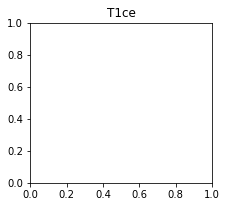

In [11]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce[400,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(seg_geniş[400,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(seg_ödemsiz[400,0,:,:])

In [12]:
def tümör_kırpma(mr,seg):
    
    mr = mr[0]
    liste = []
    tmp = seg[0,:,:]
    tmp[tmp>0.2] = 1
    tmp[tmp!= 1] = 0
    index_xy = np.where(tmp==1)    
    if index_xy[0] != []:
        merkez_y = (max(index_xy[0]) + (min(index_xy[0])) ) / 2
        merkez_x = (max(index_xy[1]) + (min(index_xy[1])) ) / 2
        img_x =  np.zeros((64,64), np.float32)
        img_x[:,:] = mr[int(merkez_y - 64/2):int(merkez_y + 64/2),int(merkez_x - 64/2):int(merkez_x + 64/2) ]
        liste.append(img_x)    
    return np.array(liste)
def tumortoarray(tumor,segmentasyon):
    liste_boş= []
    for i in range(len(segmentasyon)):
        img = tümör_kırpma(tumor[i],segmentasyon[i])
        if len(img.shape) > 2:
            liste_boş.append(img)
            print(f'{i}')
    return np.array(liste_boş)

ödemsiz = tumortoarray(seg_ödemsiz,seg_ödemsiz)
geniş = tumortoarray(seg_geniş,seg_ödemsiz)
t1ce_kırp = tumortoarray(t1ce,seg_ödemsiz)

NameError: name 'seg_ödemsiz' is not defined

In [13]:
t1ce_kırp.shape, ödemsiz.shape, geniş.shape

NameError: name 't1ce_kırp' is not defined

NameError: name 't1ce_kırp' is not defined

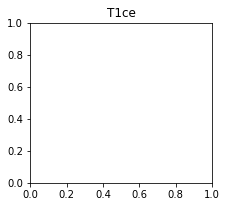

In [14]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce_kırp[405,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(geniş[405,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(ödemsiz[405,0,:,:])

In [15]:
def unet_model_7():
    
    inputs = Input((1, 64, 64))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
     
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch5)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [16]:
model_ödemsiz = unet_model_7()

In [17]:
history = model_ödemsiz.fit(t1ce_kırp, ödemsiz,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

NameError: name 't1ce_kırp' is not defined

In [18]:
model_geniş = unet_model_7()

In [19]:
history = model_geniş.fit(t1ce_kırp, geniş,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

NameError: name 't1ce_kırp' is not defined

In [20]:
model_ödemsiz.load_weights('/content/drive/MyDrive/adamınyaptığıbitirmeödevi/ödemsiz.h5')
model_geniş.load_weights('/content/drive/MyDrive/adamınyaptığıbitirmeödevi/geniş.h5')
#model_ödemsiz.load_weights('/content/ödemsiz.h5')
#model_geniş.load_weights('/content/geniş.h5')

OSError: Unable to open file (unable to open file: name = '/content/drive/MyDrive/adamınyaptığıbitirmeödevi/ödemsiz.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

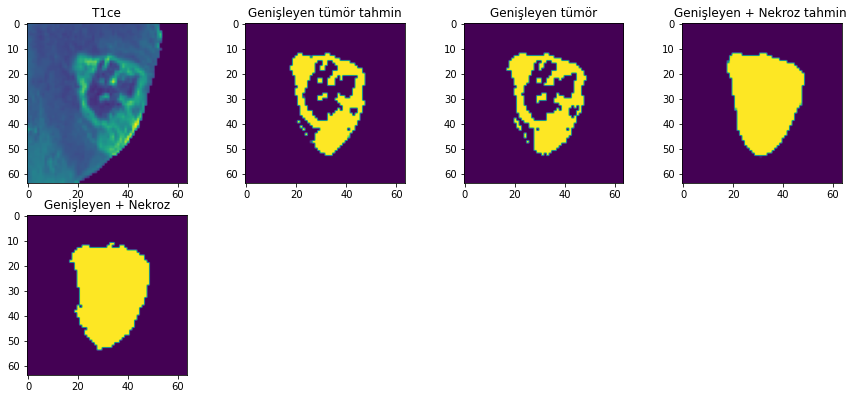

In [27]:
x = 300

plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce_kırp[x,0,:,:])


pred_geniş = model_geniş.predict(t1ce_kırp[x:x+1,:,:,:])
plt.subplot(3,4,2)
plt.title('Genişleyen tümör tahmin')
plt.imshow(pred_geniş[0,0,:,:] )

plt.subplot(3,4,3)
plt.title('Genişleyen tümör')
plt.imshow(geniş[x,0,:,:])

pred_ödemsiz = model_ödemsiz.predict(t1ce_kırp[x:x+1,:,:,:])
plt.subplot(3,4,4)
plt.title('Genişleyen + Nekroz tahmin ')
plt.imshow(pred_ödemsiz[0,0,:,:] )


plt.subplot(3,4,5)
plt.title('Genişleyen + Nekroz')
plt.imshow(ödemsiz[x,0,:,:])

In [28]:
def tümör_kırp(x, pred, size): 
    crop_x = []
    list_xy = []
    p_tmp = pred[0,:,:]
    p_tmp[p_tmp>0.2] = 1    
    p_tmp[p_tmp !=1] = 0
    index_xy = np.where(p_tmp==1)  

    if index_xy[0].shape[0] == 0: 
        return [],[]
        
    center_x = (max(index_xy[0]) + min(index_xy[0])) / 2 
    center_y = (max(index_xy[1]) + min(index_xy[1])) / 2 
    
    if center_x >= 176:
            center_x = center_x-8
        
    length = max(index_xy[0]) - min(index_xy[0])
    width = max(index_xy[1]) - min(index_xy[1])
        
    if width <= 64 and length <= 64:  #64x64
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y - size/2)))
            
    if width > 64 and length <= 64:  #64x128
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y)))
            
    if width <= 64 and length > 64:  #128x64       
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size/2)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size/2)))
            
    if width > 64 and length > 64:  #128x128
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y)))
        
    
        
    return np.array(crop_x) , list_xy   

In [29]:
sayı = 210

görüntü1, kordinat1 = tümör_kırp(t1ce[50,:,:,:],seg[50,:,:],64)
görüntü2, kordinat2 = tümör_kırp(seg_geniş[50,:,:,:],seg[50,:,:,:],64)
görüntü3, kordinat3 = tümör_kırp(seg_ödemsiz[50,:,:,:],seg[50,:,:,:],64)

In [30]:
görüntü1.shape, görüntü2.shape, görüntü3.shape

((1, 1, 64, 64), (1, 1, 64, 64), (1, 1, 64, 64))

In [31]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('t1ce')
plt.imshow(t1ce[sayı,0,:,:])

plt.subplot(3,4,2)
plt.title('t1ce kırpılmış (1. kırpma)')
plt.imshow(görüntü1[0,0,:,:])

plt.subplot(3,4,3)
plt.title('genişleyen tümör')
plt.imshow(görüntü2[0,0,:,:])

plt.subplot(3,4,4)
plt.title('genişleyen tümör')
plt.imshow(görüntü2[1,0,:,:])

plt.subplot(3,4,5)
plt.title('genişleyen tümör')
plt.imshow(görüntü2[2,0,:,:])

plt.subplot(3,4,6)
plt.title('genişleyen tümör')
plt.imshow(görüntü2[3,0,:,:])

plt.subplot(3,4,7)
plt.title('genişleyen + nekroz')
plt.imshow(görüntü3[0,:,:])

SyntaxError: ignored

In [32]:
def tumor2array(tumor,segmentasyon):

    liste = []

    for i in range(len(tumor)):
        crop , kordinat = tümör_kırp(tumor[i,:,:,:],segmentasyon[i,:,:,:],64)
    
        if crop == []:
            pass
        elif crop.shape[0] ==1:
            liste.append(crop[0])
        
        elif crop.shape[0] ==2:
        
           liste.append(crop[0])
           liste.append(crop[1])
        
        elif crop.shape[0] ==4:
        
            liste.append(crop[0])
            liste.append(crop[1])
            liste.append(crop[2])
            liste.append(crop[3]) 
    
    return np.array(liste)

In [33]:
t1ce_array = tumor2array(t1ce,seg)
geniş_array = tumor2array(seg_geniş,seg)
ödemsiz_array = tumor2array(seg_ödemsiz,seg)
t1ce_array.shape, ödemsiz_array.shape, geniş_array.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


((2973, 1, 64, 64), (2973, 1, 64, 64), (2973, 1, 64, 64))

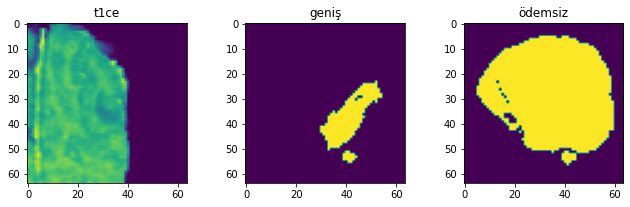

In [34]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('t1ce')
plt.imshow(t1ce_array[70,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(geniş_array[40,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(ödemsiz_array[40,0,:,:])

In [35]:
model_ödemsiz_2 = unet_model_7()

In [36]:
history = model_ödemsiz_2.fit(t1ce_array, ödemsiz_array,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
238/238 [==============================] - 12s 44ms/step - loss: 0.6632 - dice_coef: 0.3368 - val_loss: 0.7808 - val_dice_coef: 0.2173
Epoch 2/5
238/238 [==============================] - 9s 40ms/step - loss: 0.3690 - dice_coef: 0.6310 - val_loss: 0.6889 - val_dice_coef: 0.3085
Epoch 3/5
238/238 [==============================] - 10s 41ms/step - loss: 0.2563 - dice_coef: 0.7437 - val_loss: 0.5485 - val_dice_coef: 0.4477
Epoch 4/5
238/238 [==============================] - 10s 40ms/step - loss: 0.2137 - dice_coef: 0.7863 - val_loss: 0.4917 - val_dice_coef: 0.5040
Epoch 5/5
238/238 [==============================] - 9s 40ms/step - loss: 0.1551 - dice_coef: 0.8449 - val_loss: 0.5187 - val_dice_coef: 0.4773


In [37]:
model_geniş_2 = unet_model_7()

In [38]:
history = model_geniş_2.fit(t1ce_array, geniş_array,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
238/238 [==============================] - 11s 41ms/step - loss: 0.7916 - dice_coef: 0.2084 - val_loss: 0.7578 - val_dice_coef: 0.2402
Epoch 2/5
238/238 [==============================] - 9s 39ms/step - loss: 0.5761 - dice_coef: 0.4239 - val_loss: 0.5389 - val_dice_coef: 0.4573
Epoch 3/5
238/238 [==============================] - 9s 39ms/step - loss: 0.4271 - dice_coef: 0.5729 - val_loss: 0.4907 - val_dice_coef: 0.5051
Epoch 4/5
238/238 [==============================] - 9s 39ms/step - loss: 0.3404 - dice_coef: 0.6596 - val_loss: 0.6206 - val_dice_coef: 0.3762
Epoch 5/5
238/238 [==============================] - 9s 39ms/step - loss: 0.2776 - dice_coef: 0.7224 - val_loss: 0.4976 - val_dice_coef: 0.4982


In [39]:
model_ödemsiz_2.load_weights('/content/drive/MyDrive/adamınyaptığıbitirmeödevi/ödemsiz.h5')
model_geniş_2.load_weights('/content/drive/MyDrive/adamınyaptığıbitirmeödevi/geniş.h5')
model.load_weights('/content/drive/MyDrive/adamınyaptığıbitirmeödevi/tam.h5')
# model_ödemsiz_2.load_weights('/content/ödemsiz.h5')
# model_geniş_2.load_weights('/content/geniş.h5')
# model.load_weights('/content/tam.h5')

In [40]:
görüntü , koordinat = tümör_kırp(t1ce[1020,:,:,:],seg[1020,:,:,:],64)

In [41]:
görüntü.shape

(4, 1, 64, 64)

In [42]:
pred_ödemsiz = model_ödemsiz.predict(görüntü)
pred_geniş = model_geniş.predict(görüntü)
pred_tam = model.predict(x_train[1020:1021,:,:,:])

In [43]:
pred_tam[pred_tam > 0.2] = 2
pred_tam[pred_tam != 2 ] = 0

pred_ödemsiz[pred_ödemsiz > 0.2] = 1
pred_ödemsiz[pred_ödemsiz != 1 ] = 0

pred_geniş[pred_geniş > 0.2] = 4
pred_geniş[pred_geniş != 4 ] = 0

In [44]:
def üstüne_ekle(pred_tam, pred_ödemsiz , pred_geniş , koordinat):  
    
    total = np.zeros((1,240,240),np.float32)  
    total[:,:,:] = pred_tam[:,:,:]
    
    for i in range(pred_ödemsiz.shape[0]):
        for j in range(64):
            for k in range(64):
                
                if pred_ödemsiz[i,0,j,k] != 0 and pred_tam[0,koordinat[i][0]+j,koordinat[i][1]+k] !=0:
                    total[0,koordinat[i][0]+j,koordinat[i][1]+k] = pred_ödemsiz[i,0,j,k]
                    
                if pred_geniş[i,0,j,k] != 0 and pred_tam[0,koordinat[i][0]+j,koordinat[i][1]+k] !=0:
                    total[0,koordinat[i][0]+j,koordinat[i][1]+k] = pred_geniş[i,0,j,k]
                
    return total

In [45]:
deneme = üstüne_ekle(pred_tam[0,:,:,:], pred_ödemsiz, pred_geniş, koordinat)

In [46]:
deneme.shape

(1, 240, 240)

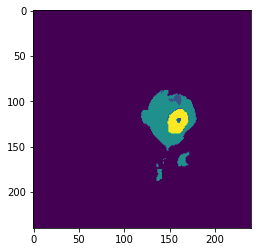

In [47]:
plt.imshow(deneme[0])

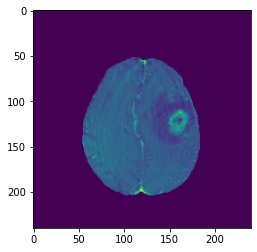

In [48]:
plt.imshow(t1ce[1020,0,:,:])

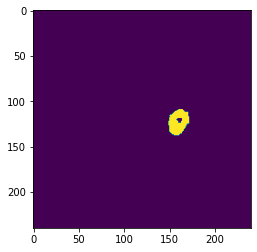

In [49]:
plt.imshow(seg_geniş[1020,0,:,:])

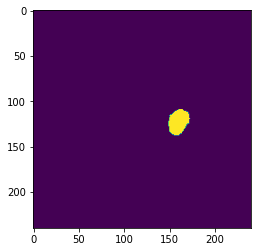

In [50]:
plt.imshow(seg_ödemsiz[1020,0,:,:])